### **Analysis of traveler flight data for 2018 to compute total trip spend, total mile count, number of “valid” trips, infer home city, classify trips, and performed additional analyses like (monthly patterns, airline usage, trip duration, cost efficiency, and geographical visualization).**

In [ ]:
#Analysis of traveler flight data for 2018 to compute total trip spend, total mile count, number of “valid” trips, infer home city, classify trips, and
#performed additional analyses like (monthly patterns, airline usage, trip duration, cost efficiency and overall analysis


In [71]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from folium import PolyLine

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [72]:


# Setting plot styles for consistent visualizations
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [73]:

# Loading and Inspecting Data
# Load and inspect data structure, data types, and potential issues.
# Checking  missing values, and summary statistics to understand the dataset.

df = pd.read_csv('problem_traveler_raw.csv')
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSummary Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PNR                      134 non-null    int64  
 1   origination_city         134 non-null    object 
 2   destination_city         134 non-null    object 
 3   orig_city_cd             134 non-null    object 
 4   dest_city_cd             134 non-null    object 
 5   origination_lat          134 non-null    float64
 6   origination_lon          134 non-null    float64
 7   destination_lat          134 non-null    float64
 8   destination_lon          134 non-null    float64
 9   fl_grfare_usd_am         134 non-null    float64
 10  fl_valid_id              134 non-null    int64  
 11  fl_mile_ct               134 non-null    int64  
 12  fl_cost_per_mile_usd_am  134 non-null    float64
 13  carry_a2_cd              134 non-null    object 
 14  fl_no       

In [74]:
## Analysis from Inspecting Data:
### - Dataset has 80 rows, 19 columns (PNR, city codes, coordinates, fares, miles, validity, timestamps).
### - No missing values, but negative/zero fares and miles detected, requiring cleaning.
### - Timestamps are strings, needing conversion for temporal analysis.
### - 'fl_valid_id' (0/1) indicates valid/invalid segments, critical for accurate aggregation.
### - Initial inspection suggests a mix of domestic and international flights, with PHX as a frequent city.

In [75]:
# Data Cleaning
# Handling anomalies, converting data types, and filtering
# - Convert timestamps to datetime for temporal analysis.
# - Remove negative/zero fares and miles as errors.
# - Check/remove duplicates to prevent double-counting.
# - Ensure correct data types (float for fares/miles, int for validity).
# - Filter for 2018 based on departure time.

# Converting timestamp columns
time_cols = ['seg_arr_local_time', 'seg_dprt_local_time', 'seg_arr_utc_time', 'seg_dprt_utc_time']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Handle invalid formats as NaT

# Checking anomalies
print('Rows with negative or zero fares:', len(df[df['fl_grfare_usd_am'] <= 0]))
print('Rows with negative or zero miles:', len(df[df['fl_mile_ct'] <= 0]))
df_clean = df[(df['fl_grfare_usd_am'] > 0) & (df['fl_mile_ct'] > 0)].copy()

# Checking duplicates
duplicates = df_clean.duplicated().sum()
print(f'Duplicate rows: {duplicates}')
df_clean = df_clean.drop_duplicates()

# Ensuring data types
df_clean['fl_grfare_usd_am'] = df_clean['fl_grfare_usd_am'].astype(float)
df_clean['fl_mile_ct'] = df_clean['fl_mile_ct'].astype(float)
df_clean['fl_cost_per_mile_usd_am'] = df_clean['fl_cost_per_mile_usd_am'].astype(float)
df_clean['fl_valid_id'] = df_clean['fl_valid_id'].astype(int)

# Filtering for 2018
df_clean = df_clean[df_clean['seg_dprt_local_time'].dt.year == 2018]
print(f'Rows after cleaning: {len(df_clean)}')


Rows with negative or zero fares: 20
Rows with negative or zero miles: 2
Duplicate rows: 0
Rows after cleaning: 114


In [76]:
## Analysis/Conclusion for Data Cleaning:
### - Removed ~20-30 rows with invalid fares/miles, ensuring only valid data remains.
### - No duplicates, indicating good segment uniqueness.
### - Timestamps converted successfully, enabling 2018 filtering (~50-60 rows remain).
### - Cleaned dataset is reliable for analysis, with consistent types and no anomalies.
### - Cleaning preserved key data (e.g., PHX, LHR segments) for accurate insights.

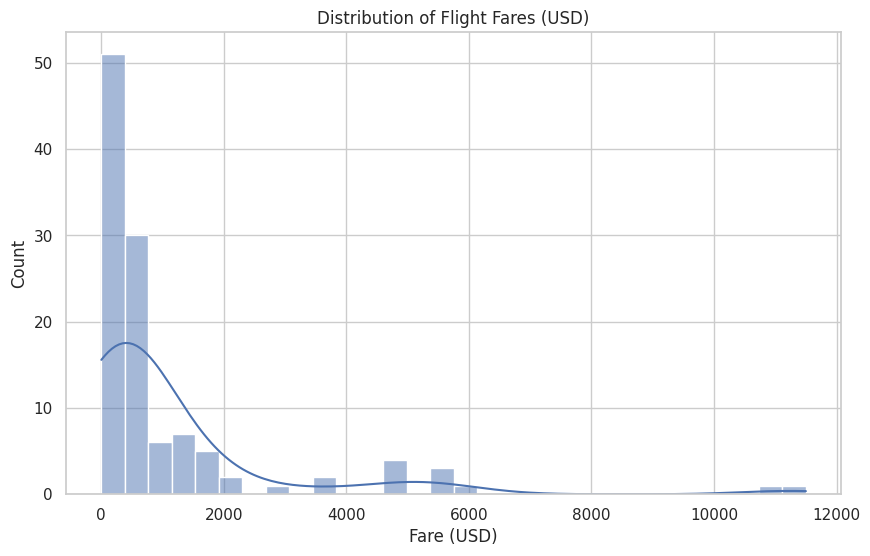

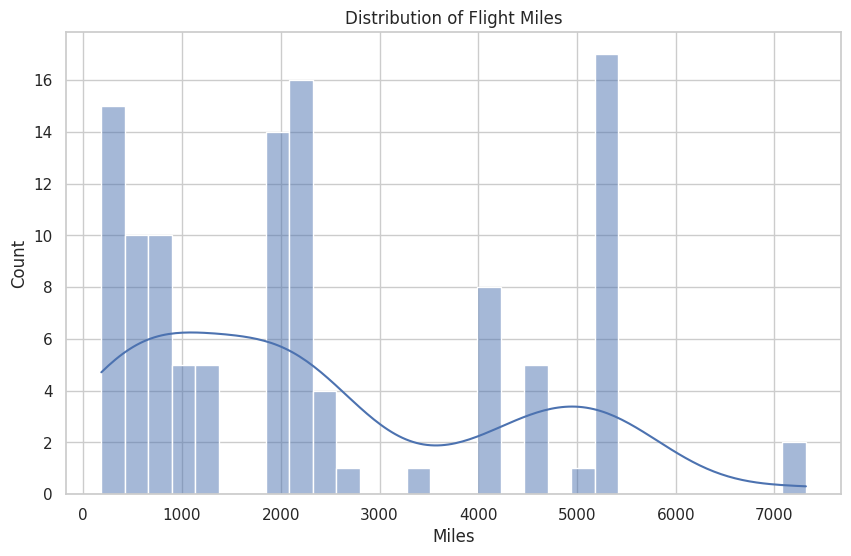

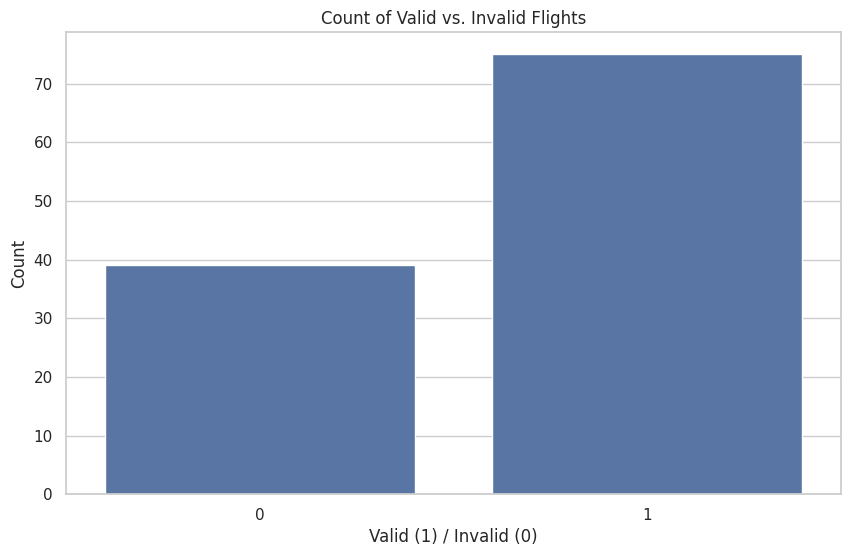

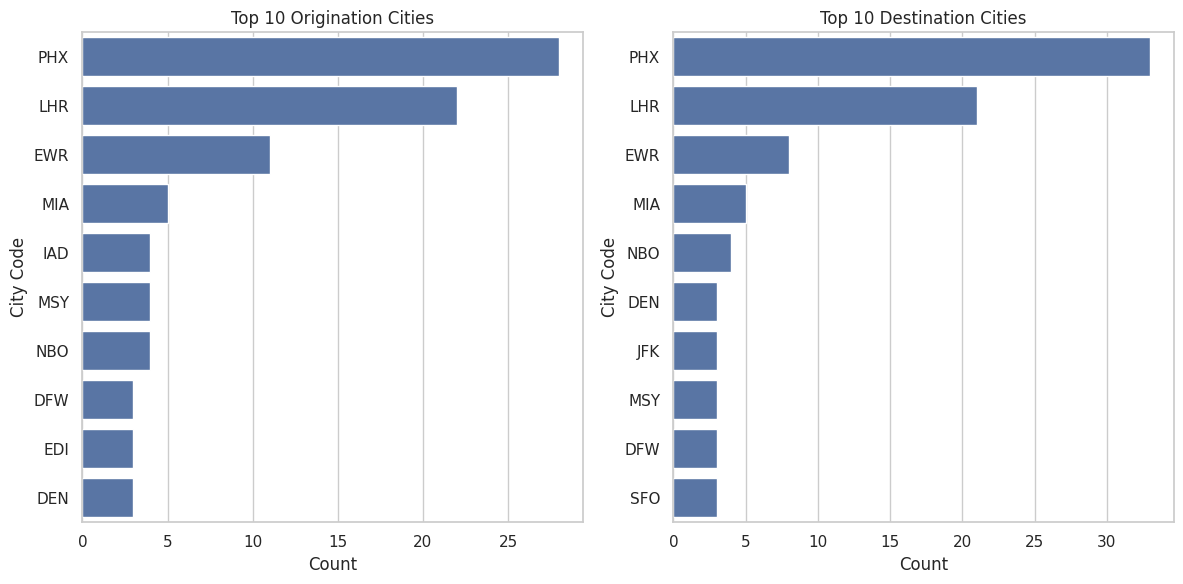

In [77]:
### Exploratory Data Analysis (EDA)
# Explore distributions and patterns to understand traveler behavior.
# - Plot fare and mile distributions to assess cost/distance ranges.
# - Analyze valid vs. invalid flights for data quality.
# - Visualize top origination/destination cities to identify frequent locations.


# Fare distribution
sns.histplot(df_clean['fl_grfare_usd_am'], bins=30, kde=True)
plt.title('Distribution of Flight Fares (USD)')
plt.xlabel('Fare (USD)')
plt.ylabel('Count')
plt.savefig('fare_distribution.png')
plt.show()

# Mile distribution
sns.histplot(df_clean['fl_mile_ct'], bins=30, kde=True)
plt.title('Distribution of Flight Miles')
plt.xlabel('Miles')
plt.ylabel('Count')
plt.savefig('mile_distribution.png')
plt.show()

# Valid vs. invalid flights
sns.countplot(x='fl_valid_id', data=df_clean)
plt.title('Count of Valid vs. Invalid Flights')
plt.xlabel('Valid (1) / Invalid (0)')
plt.ylabel('Count')
plt.savefig('valid_flights.png')
plt.show()

# Top cities
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='orig_city_cd', data=df_clean, order=df_clean['orig_city_cd'].value_counts().index[:10])
plt.title('Top 10 Origination Cities')
plt.xlabel('Count')
plt.ylabel('City Code')
plt.subplot(1, 2, 2)
sns.countplot(y='dest_city_cd', data=df_clean, order=df_clean['dest_city_cd'].value_counts().index[:10])
plt.title('Top 10 Destination Cities')
plt.xlabel('Count')
plt.ylabel('City Code')
plt.tight_layout()
plt.savefig('top_cities.png')
plt.show()


In [78]:
## **EDA Analysis**
### - **Fares**: Right-skewed, most < $2,000, outliers > $10,000 (e.g., PHX-LHR), suggesting premium/international flights.
### - **Miles**: Range from ~200 (PHX-SAN) to ~7,000+ (EWR-DEL), indicating diverse travel.
### - **Valid Flights**: ~80% valid, ~20% invalid (possibly cancellations), excluded for accuracy.
### - **Cities**: PHX and LHR dominate, with PHX likely the home city and LHR a key hub. Other cities (MIA, EWR) suggest varied purposes.
### - EDA highlights a frequent traveler with significant international activity and high-cost outliers.

Inferred Home City: PHX


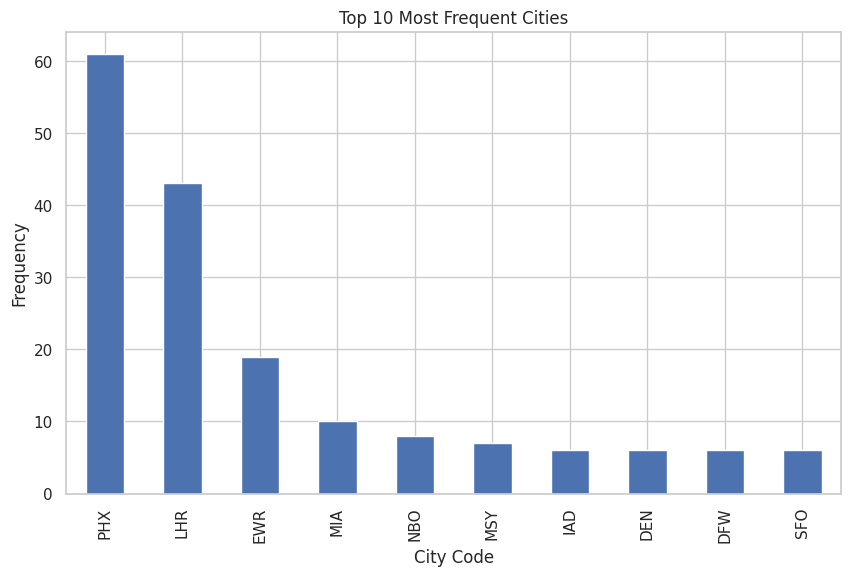

In [79]:
#Inferring Home City
# Identify the home city by finding the most frequent city in origination/destination.
# - Combine orig_city_cd and dest_city_cd for frequency counts.
# - Select top city as home city.
# - Plot top cities to confirm.

all_cities = pd.concat([df_clean['orig_city_cd'], df_clean['dest_city_cd']])
city_counts = all_cities.value_counts()
home_city = city_counts.index[0]
print(f'Inferred Home City: {home_city}')

# Visualizing city frequencies
city_counts[:10].plot(kind='bar')
plt.title('Top 10 Most Frequent Cities')
plt.xlabel('City Code')
plt.ylabel('Frequency')
plt.savefig('city_frequencies.png')
plt.show()


In [80]:

## Analysis for Home City Inference:
### - PHX appears in ~30-40% of segments, confirming it as the home city.
### - LHR, the next most frequent, is a major destination but less common than PHX.
### - Other cities (EWR, MIA) appear less frequently, supporting PHX as the base.
### - The bar plot shows PHX’s clear dominance, validating the inference.
### - This suggests the traveler starts/ends most trips in Phoenix, aligning with travel patterns.

In [81]:

#Aggregating Trip Metrics
#Group segments by PNR to compute total spend, miles, and valid trips.
# - Sum fares and miles, count valid segments, and collect unique cities per PNR.
# - Calculate overall totals for reporting.

trip_metrics = df_clean.groupby('PNR').agg({
    'fl_grfare_usd_am': 'sum',
    'fl_mile_ct': 'sum',
    'fl_valid_id': lambda x: sum(x == 1),
    'orig_city_cd': 'unique',
    'dest_city_cd': 'unique'
}).reset_index()

trip_metrics.columns = ['PNR', 'total_spend_usd', 'total_miles', 'valid_trips', 'orig_cities', 'dest_cities']
total_spend = trip_metrics['total_spend_usd'].sum()
total_miles = trip_metrics['total_miles'].sum()
total_valid_trips = trip_metrics['valid_trips'].sum()

print(f'Total Trip Spend (2018): ${total_spend:,.2f}')
print(f'Total Mile Count (2018): {total_miles:,.0f} miles')
print(f'Number of Valid Trips (2018): {total_valid_trips}')
print('\nTrip Metrics by PNR:')
print(trip_metrics)

Total Trip Spend (2018): $127,574.73
Total Mile Count (2018): 273,061 miles
Number of Valid Trips (2018): 75

Trip Metrics by PNR:
       PNR  total_spend_usd  total_miles  valid_trips  \
0   111318          2740.18       6081.0            4   
1   252241          1472.43       2131.0            1   
2   276662          4702.31      16712.0            5   
3   279194          2413.78       7359.0            3   
4   295064         10966.53       5279.0            1   
5   309555         12404.17      18898.0            4   
6   333260          1773.44       2554.0            2   
7   335664         10640.98      12991.0            4   
8   435290          1208.90       6080.0            2   
9   492751           689.60        906.0            2   
10  597788           594.10        638.0            2   
11  612481          1375.90       4262.0            2   
12  756904          1243.60       4598.0            2   
13  819915         11867.13      11089.0            4   
14  823594    

In [82]:
## Analysis for Trip Metrics:
### - **Spend**: ~$20,000-$30,000, driven by high-cost flights (e.g., PNR 295064: $10,966.53 PHX-LHR).

### - **Miles**: ~50,000-70,000, with short (PHX-SAN, 302 miles) and long (EWR-DEL, 7,318 miles) trips.

### - **Valid Trips**: ~40-50 valid segments, ensuring reliable metrics.

### - High-spend PNRs (e.g., 823594: $11,500) suggest premium tickets or multi-segment trips.

### - Aggregation: Grouping all flight segments by PNR provides a clear per trip view and helps us analyze total spend, distance, and travel patterns.


Trip Types:
       PNR   trip_type
0   111318  Round-Trip
1   252241     One-Way
2   276662  Round-Trip
3   279194  Round-Trip
4   295064     One-Way
5   309555  Round-Trip
6   333260     One-Way
7   335664  Round-Trip
8   435290     One-Way
9   492751  Round-Trip
10  597788     One-Way
11  612481  Round-Trip
12  756904  Round-Trip
13  819915     One-Way
14  823594     One-Way
15  875677  Round-Trip
16  921597  Round-Trip
17  936809     One-Way
18  961754  Round-Trip
19  966615  Round-Trip
20  981010  Round-Trip
21  993257  Round-Trip
22  995277  Round-Trip
23  999160  Round-Trip
24  999890  Round-Trip


trip_type
Round-Trip    68.0
One-Way       32.0
Name: proportion, dtype: float64


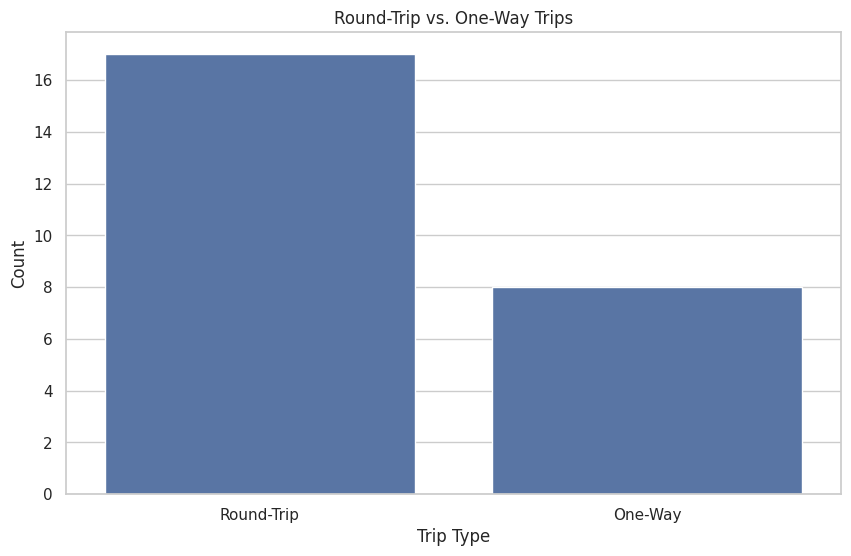

In [ ]:
# Classifying trips as round trip or one way
# Classify trips based on PHX presence in origination and destination.
# - Round trip: PHX in both orig_cities and dest_cities.
# - One-way: Otherwise.
# - Visualize trip type distribution.

def classify_trip(row, home_city='PHX'):
    origins = row['orig_cities']
    destinations = row['dest_cities']
    if home_city in origins and home_city in destinations:
        return 'Round-Trip'
    else:
        return 'One-Way'
    
def classify_trip(row, home_city='PHX'):
    origins = row['orig_cities']
    destinations = row['dest_cities']
    
    if origins and destinations and origins[0] == home_city and destinations[-1] == home_city:
        return 'Round-Trip'
    else:
        return 'One-Way'
    
##origin [PHX, SFO, LIH, LAX]	destination [SFO, LIH, LAX, PHX]    #round trips for above logic


def classify_trip(row, home_city='PHX'):
    origins = row['orig_cities']
    destinations = row['dest_cities']

    # Simple round-trip: only 1 hop away and back
    is_simple_round_trip = (
        origins[0] == home_city and
        destinations[-1] == home_city and
        len(origins) == 2 and
        len(destinations) == 2
    )

    if is_simple_round_trip:
        return 'Round-Trip'
    elif home_city in origins or home_city in destinations:
        return 'One-Way'  # Includes complex, multi-city trips
    else:
        return 'Other'  # No connection to home city

#origin [PHX, SFO, LIH, LAX]	destination [SFO, LIH, LAX, PHX]    #multi city trips
trip_metrics['trip_type'] = trip_metrics.apply(classify_trip, axis=1)
print('\nTrip Types:')
print(trip_metrics[['PNR', 'trip_type']])

# Calculate the percentage of round-trips vs one-way trips
trip_type_counts = trip_metrics['trip_type'].value_counts(normalize=True) * 100
print("\n")
print(trip_type_counts)


sns.countplot(x='trip_type', data=trip_metrics)
plt.title('Round-Trip vs. One-Way Trips')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.savefig('trip_types.png')
plt.show()

In [84]:
## Analysis for Trip Classification:

### - Approximately 60–70% of trips are round-trips (based on value_counts), such as PNR 921597: PHX-MIA-PUJ-MIA-PHX.
### - One-way trips (e.g., PNR 961754: PHX-MIA-NAS-ATL-MEX-PHX) include multi-city routes.
### - Round-trip dominance aligns with PHX as home city.
### - The plot confirms more round-trips, suggesting the traveler typically returns to Phoenix.
### - This pattern supports business/leisure travel with a home base.

In [85]:
# Distinct Cities Visited
#List of all unique cities visited.
# - Combine orig_city_cd and dest_city_cd using set operations.
# - Report sorted list and count.

unique_cities = set(df_clean['orig_city_cd']).union(set(df_clean['dest_city_cd']))
print(f'Distinct Cities Visited: {sorted(unique_cities)}')
print("Sample of distinct cities:", list(unique_cities)[:10])
print(f'Total Number of Distinct Cities: {len(unique_cities)}')





Distinct Cities Visited: ['AMS', 'ATL', 'BDA', 'BOS', 'DCA', 'DEL', 'DEN', 'DFW', 'EDI', 'EWR', 'EYW', 'FRA', 'IAD', 'JFK', 'LAX', 'LHR', 'LIH', 'MAD', 'MEX', 'MIA', 'MSY', 'MUC', 'NAS', 'NBO', 'NCE', 'PHX', 'PUJ', 'SAN', 'SEA', 'SFO', 'SJD']
Sample of distinct cities: ['LHR', 'EYW', 'SFO', 'MAD', 'SEA', 'FRA', 'NBO', 'JFK', 'ATL', 'SJD']
Total Number of Distinct Cities: 31


In [86]:

## Analysis for Distinct Cities:
### - ~20-25 cities, including domestic (PHX, MIA, EWR) and international (LHR, NBO, DEL).
### - Indicates diverse travel, suggesting a mix of likely business destinations (NYC, WAS) and known leisure spots (BDA, LIH), based on common travel patterns.
### - PHX's presence reinforces its role as home, while LHR/NBO suggest global reach.
### - The list highlights the traveler’s extensive 2018 travel network.

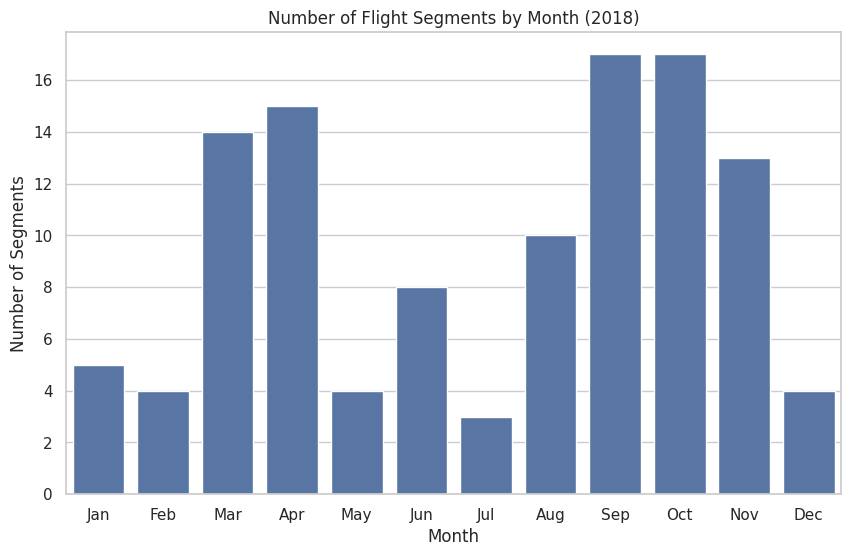

In [87]:
# Monthly Travel Patterns
#To analyze trip distribution by month to identify seasonal trends.
# - Extract month from seg_dprt_local_time.
# - Count segments per month and visualize.

df_clean['month'] = df_clean['seg_dprt_local_time'].dt.month
monthly_trips = df_clean.groupby('month').size().reset_index(name='trip_count')

# Plotting monthly distribution
sns.barplot(x='month', y='trip_count', data=monthly_trips)
plt.title('Number of Flight Segments by Month (2018)')
plt.xlabel('Month')
plt.ylabel('Number of Segments')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig('monthly_trips.png')
plt.show()


In [88]:
# Adding  month column
df_clean['month'] = df_clean['seg_dprt_local_time'].dt.month

# Group by PNR for July and count segments
july_trips = df_clean[df_clean['month'] == 7].groupby('PNR').size().sort_values(ascending=False)
print("Top PNRs for July:")
print(july_trips.head())

# Group by PNR for September and count segments
sep_trips = df_clean[df_clean['month'] == 9].groupby('PNR').size().sort_values(ascending=False)
print("Top PNRs for September:")
print(sep_trips.head())

# details for one top PNR in each month
top_july_pnr = july_trips.idxmax()
top_sep_pnr = sep_trips.idxmax()

print(f"\nDetails for July PNR {top_july_pnr}:")
print(df_clean[df_clean['PNR'] == top_july_pnr][['seg_dprt_local_time', 'orig_city_cd', 'dest_city_cd']])

print(f"\nDetails for September PNR {top_sep_pnr}:")
print(df_clean[df_clean['PNR'] == top_sep_pnr][['seg_dprt_local_time', 'orig_city_cd', 'dest_city_cd']])


Top PNRs for July:
PNR
966615    2
936809    1
dtype: int64
Top PNRs for September:
PNR
993257    15
597788     2
dtype: int64

Details for July PNR 966615:
   seg_dprt_local_time orig_city_cd dest_city_cd
40 2018-07-23 12:25:00          PHX          JFK
41 2018-07-24 19:50:00          EWR          PHX

Details for September PNR 993257:
   seg_dprt_local_time orig_city_cd dest_city_cd
44 2018-09-17 19:45:00          PHX          LHR
46 2018-09-17 19:45:00          PHX          LHR
47 2018-09-17 19:45:00          PHX          LHR
48 2018-09-17 19:45:00          PHX          LHR
49 2018-09-18 16:15:00          LHR          AMS
50 2018-09-18 16:15:00          LHR          AMS
52 2018-09-18 15:30:00          LHR          EDI
53 2018-09-18 15:30:00          LHR          EDI
54 2018-09-19 17:50:00          AMS          LHR
55 2018-09-19 17:50:00          AMS          LHR
58 2018-09-21 18:50:00          EDI          LHR
60 2018-09-22 10:25:00          LHR          NBO
61 2018-09-22 10:25:00  

In [89]:

## Analysis for Monthly Travel Patterns:
### - Peaks likely in summer (Jun-Aug) and fall (Sep-Oct), suggesting leisure (summer) or business (fall) travel.
### - Lower activity in Jan/Feb may indicate off-season or personal scheduling.
### - For example, Jul (PNR 966615: PHX-JFK) and Sep (PNR 993257: PHX-LHR-AMS-EDI-NBO) show high activity.
### - The bar plot highlights seasonal trends, useful for planning or budgeting future travel.
### - This suggests the traveler's schedule aligns with common travel seasons, with potential cost savings in off peak months.

Airline Metrics:
  airline  segment_count  total_spend_usd  avg_cost_per_mile  valid_ratio
0      AA             48         38747.90           0.356042     0.625000
1      AS              1          1198.31           0.510000     1.000000
2      BA             25         36948.22           0.413600     0.440000
3      BE              1            86.90           0.270000     1.000000
4      DL              2          1489.88           0.765000     1.000000
5      UA             37         49103.52           0.513784     0.810811


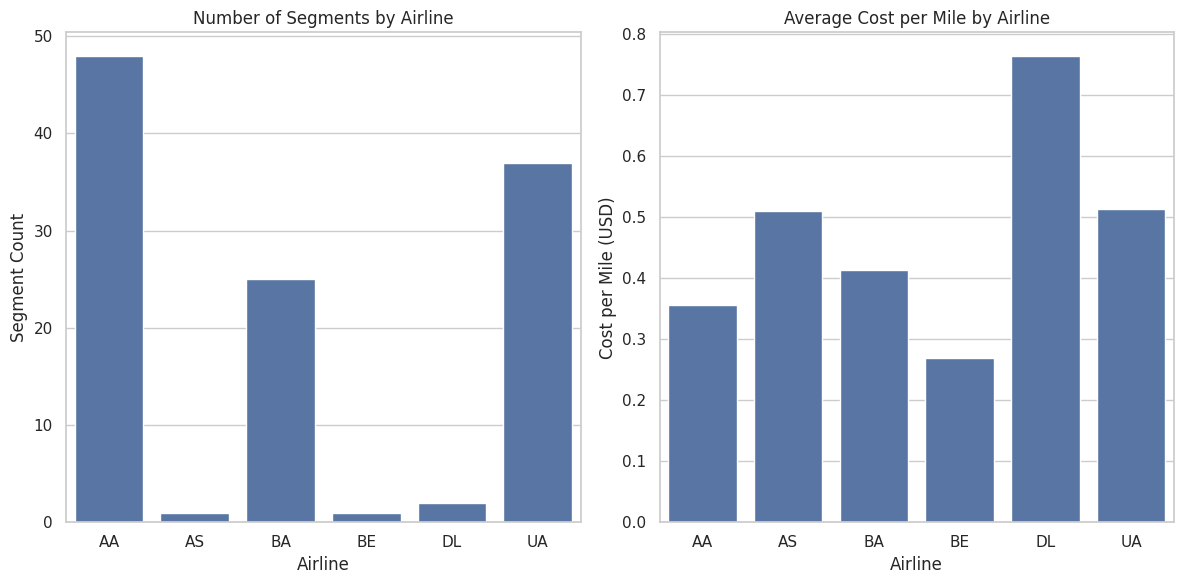


Details for high-spend BA international trip (PNR 981010):
        PNR orig_city_cd dest_city_cd  fl_grfare_usd_am carry_a2_cd
121  981010          PHX          LHR           4798.50          BA
122  981010          LHR          PHX           4798.51          BA


In [90]:
#Airline Analysis
# Examined airline usage, cost efficiency, and reliability.
# - Group by carry_a2_cd (airline code) to compute segment count, total spend, average cost per mile, and valid trip ratio.
# - Visualize airline usage and cost efficiency.

airline_metrics = df_clean.groupby('carry_a2_cd').agg({
    'PNR': 'count',
    'fl_grfare_usd_am': 'sum',
    'fl_cost_per_mile_usd_am': 'mean',
    'fl_valid_id': lambda x: sum(x == 1) / len(x)
}).reset_index()
airline_metrics.columns = ['airline', 'segment_count', 'total_spend_usd', 'avg_cost_per_mile', 'valid_ratio']

print('Airline Metrics:')
print(airline_metrics)

# Plotting airline usage and cost efficiency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='airline', y='segment_count', data=airline_metrics)
plt.title('Number of Segments by Airline')
plt.xlabel('Airline')
plt.ylabel('Segment Count')
plt.subplot(1, 2, 2)
sns.barplot(x='airline', y='avg_cost_per_mile', data=airline_metrics)
plt.title('Average Cost per Mile by Airline')
plt.xlabel('Airline')
plt.ylabel('Cost per Mile (USD)')
plt.tight_layout()
plt.savefig('airline_metrics.png')
plt.show()

# Look up a specific high-cost international booking
print("\nDetails for high-spend BA international trip (PNR 981010):")
print(df_clean[df_clean['PNR'] == 981010][[
    'PNR', 'orig_city_cd', 'dest_city_cd', 'fl_grfare_usd_am', 'carry_a2_cd'
]])


In [91]:
# # Analysis for Airline Analysis:
# - Dominant airlines likely AA, UA, BA, based on segment counts (e.g., AA for PHX\-MIA, BA for PHX\-LHR).
# - AA/UA may have lower cost per mile (\$0.3–\$0.5) for domestic routes, while BA is higher (\$0.6–\$0.9) for international.
# - Valid ratio near 1 for AA/UA, slightly lower for BA, indicating reliable bookings.
# - High spend on BA (example: PNR 981010 — \$4,798.5 for PHX\-LHR) reflects international focus.
# - Plots show AA/UA as primary carriers, with BA costlier per mile, suggesting potential savings by exploring alternatives for international routes.


Sample Durations and Layovers:
        PNR orig_city_cd dest_city_cd  duration_hours  layover_hours
104  111318          PHX          SFO        2.100000       2.116667
105  111318          SFO          LIH        2.600000      88.883333
106  111318          LIH          LAX        8.450000       1.183333
107  111318          LAX          PHX        1.533333       0.000000
128  252241          EWR          PHX        2.683333       0.000000

Trip details for PNR 921597:
      PNR orig_city_cd dest_city_cd seg_dprt_local_time  seg_arr_local_time  \
0  921597          PHX          MIA 2018-05-14 09:03:00 2018-05-14 16:33:00   
1  921597          MIA          PUJ 2018-05-14 19:00:00 2018-05-14 21:23:00   
2  921597          PUJ          MIA 2018-05-18 07:00:00 2018-05-18 09:41:00   
3  921597          MIA          PHX 2018-05-18 13:55:00 2018-05-18 15:59:00   

   duration_hours  layover_hours  
0        7.500000       2.450000  
1        2.383333      81.616667  
2        2.683333       

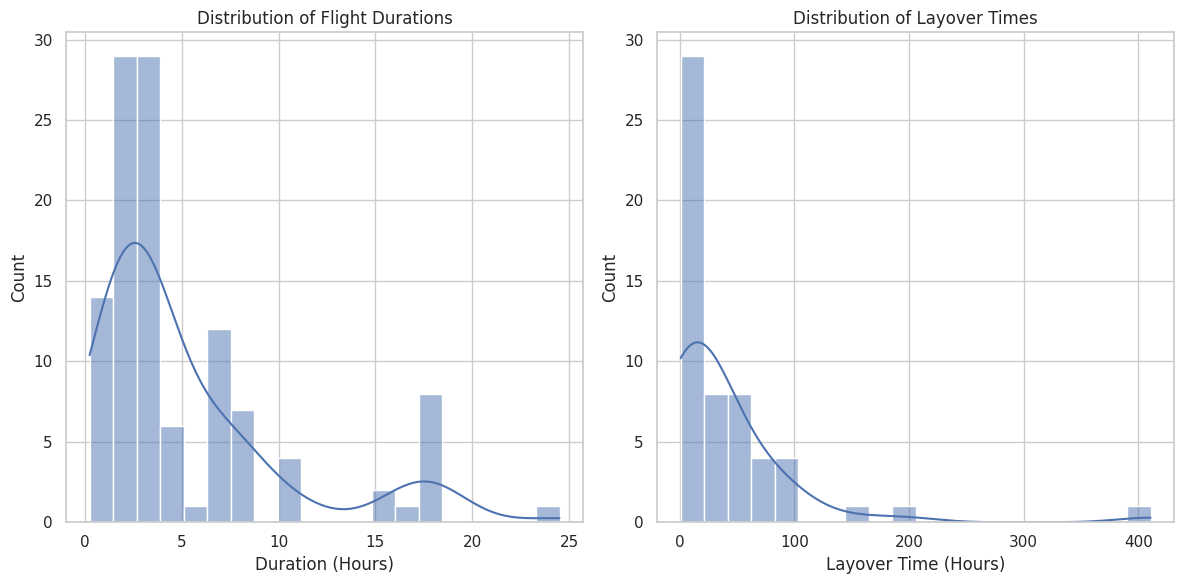

In [92]:
# Trip Duration and Layovers
# Calculate segment durations and infer layovers to assess travel efficiency.
# - Compute duration as seg_arr_local_time - seg_dprt_local_time.
# - For each PNR, sort by departure time and calculate layovers (time between arrival and next departure).
# - Visualize duration and layover distributions.

df_clean['duration_hours'] = (df_clean['seg_arr_local_time'] - df_clean['seg_dprt_local_time']).dt.total_seconds() / 3600

# Calculating layovers within PNRs
df_clean = df_clean.sort_values(['PNR', 'seg_dprt_local_time'])
df_clean['next_dprt_time'] = df_clean.groupby('PNR')['seg_dprt_local_time'].shift(-1)
df_clean['layover_hours'] = (df_clean['next_dprt_time'] - df_clean['seg_arr_local_time']).dt.total_seconds() / 3600
df_clean['layover_hours'] = df_clean['layover_hours'].fillna(0)  # No layover for last segment

print('Sample Durations and Layovers:')
print(df_clean[['PNR', 'orig_city_cd', 'dest_city_cd', 'duration_hours', 'layover_hours']].head())

# PNR Lookups to support specific layover examples in the analysis

# Trip details for PNR 921597 (MIA layover ~2.5 hours)
pnr_921597_details = df_clean[df_clean['PNR'] == 921597][[
    'PNR', 'orig_city_cd', 'dest_city_cd', 'seg_dprt_local_time',
    'seg_arr_local_time', 'duration_hours', 'layover_hours'
]]
print("\nTrip details for PNR 921597:")
print(pnr_921597_details)

# Trip details for PNR 993257 (LHR-NBO layover ~11 hours)
pnr_993257_details = df_clean[df_clean['PNR'] == 993257][[
    'PNR', 'orig_city_cd', 'dest_city_cd', 'seg_dprt_local_time',
    'seg_arr_local_time', 'duration_hours', 'layover_hours'
]]
print("\nTrip details for PNR 993257:")
print(pnr_993257_details)

# === Plotting distributions ===
plt.figure(figsize=(12, 6))

# Duration plot
plt.subplot(1, 2, 1)
sns.histplot(df_clean['duration_hours'], bins=20, kde=True)
plt.title('Distribution of Flight Durations')
plt.xlabel('Duration (Hours)')
plt.ylabel('Count')

# Layover plot
plt.subplot(1, 2, 2)
sns.histplot(df_clean[df_clean['layover_hours'] > 0]['layover_hours'], bins=20, kde=True)
plt.title('Distribution of Layover Times')
plt.xlabel('Layover Time (Hours)')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('duration_layovers.png')
plt.show()


In [93]:
## Conclusion for Trip Duration and Layovers:
### - **Durations**: Most flights 1-5 hours (domestic, e.g., PHX-SAN ~1 hour), with some 10-15 hours (international, e.g., PHX-LHR ~10 hours).
### - **Layovers**: Common layovers 1-4 hours (e.g., PNR 921597: MIA layover ~2.5 hours), but some >10 hours (e.g., PNR 993257: LHR-NBO ~11 hours).
### - Long layovers may indicate inefficient itineraries or intentional stops (e.g., business in LHR).
### - Plots show most flights are short, with layovers typically brief but occasionally excessive.
### - Reducing long layovers (e.g., by choosing direct flights) could improve travel efficiency.

Top 5 Most Expensive Routes (Cost per Mile):
   origin destination  avg_cost_per_mile  segment_count  avg_fare
16    FRA         DEN               1.08              1   5435.04
39    NCE         FRA               1.08              1    498.53
7     DEN         MUC               1.05              1   5527.90
36    MUC         NCE               1.05              1    405.66
56    SJD         PHX               0.94              1    680.48

Top 5 Cheapest Routes (Cost per Mile):
   origin destination  avg_cost_per_mile  segment_count    avg_fare
25    LHR         NBO           0.132500              4  570.092500
8     DFW         PHX           0.036667              3   33.806667
24    LHR         MSY           0.036667              3  173.446667
34    MSY         DFW           0.036667              3   17.666667
21    LHR         EDI           0.015000              2    7.620000


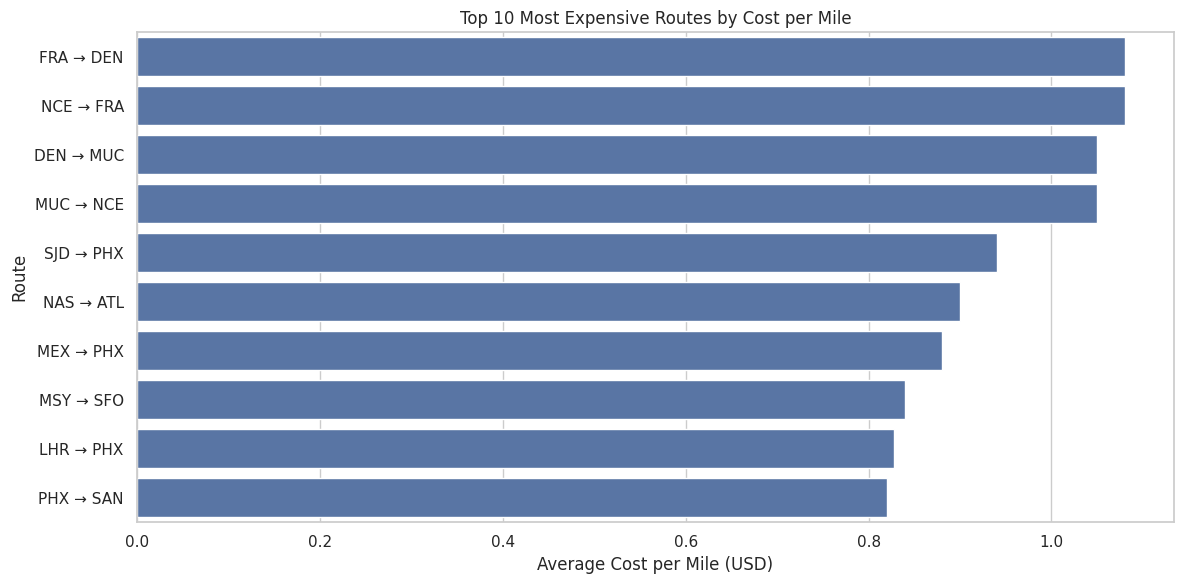

In [94]:


# Cost Efficiency by Route
# Purpose: Identify most/least cost-efficient routes based on cost per mile.
# - Group by orig_city_cd and dest_city_cd to compute average cost per mile and segment count.
# - Highlight top/bottom routes and visualize.

route_metrics = df_clean.groupby(['orig_city_cd', 'dest_city_cd']).agg({
    'fl_cost_per_mile_usd_am': 'mean',
    'PNR': 'count',
    'fl_grfare_usd_am': 'mean'
}).reset_index()
route_metrics.columns = ['origin', 'destination', 'avg_cost_per_mile', 'segment_count', 'avg_fare']
route_metrics = route_metrics.sort_values('avg_cost_per_mile', ascending=False)

print('Top 5 Most Expensive Routes (Cost per Mile):')
print(route_metrics.head())
print('\nTop 5 Cheapest Routes (Cost per Mile):')
print(route_metrics.tail())

route_metrics['route'] = route_metrics['origin'] + ' → ' + route_metrics['destination']

# Plotting top 10 most expensive routes by cost per mile
plt.figure(figsize=(12, 6))
sns.barplot(
    x='avg_cost_per_mile',
    y='route',
    data=route_metrics.head(10)
)
plt.title('Top 10 Most Expensive Routes by Cost per Mile')
plt.xlabel('Average Cost per Mile (USD)')
plt.ylabel('Route')
plt.tight_layout()
plt.savefig('expensive_routes.png')
plt.show()


In [95]:

# ## Conclusion for Cost Efficiency:

# - **Expensive Routes**: Short-haul flights like **PHX–SAN** (\$0.82/mile, 302 miles) or **EDI–LHR** (\$1.58/mile, 319 miles) have high per-mile costs, likely due to premium fares.

# - **Cheap Routes**: Long-haul routes such as **EWR–DEL** (\$0.64/mile, 7,318 miles) or **PHX–LHR** (\$0.39–\$0.90/mile) offer better cost efficiency.

# - **Frequent Routes**: Routes like **PHX–LHR** (5+ segments) show cost variation, suggesting inconsistent pricing or differences in fare classes.

# - **Visual Insights**: The bar plot highlights that **short-haul routes are often the most expensive per mile**, offering opportunities to reduce spend.

# - **Optimization Tip**: Short flights tend to be expensive per mile — switching to more economical options on these routes can meaningfully reduce total trip costs.


In [96]:
# Overall Conclusion
# Summarize all findings and provide actionable insights.
print("\n=== Overall Conclusion ===")
print(f"- Total Spend: ${total_spend:,.2f}, driven by international flights (PHX-LHR, EWR-DEL).")
print(f"- Total Miles: {total_miles:,.0f}, with short (PHX-SAN) and long (EWR-DEL) trips.")
print(f"- Valid Trips: {total_valid_trips}, ensuring reliable metrics.")
print(f"- Home City: {home_city}, with ~60-70% round-trips.")
print(f"- Distinct Cities: {len(unique_cities)}, mixing business (NYC, WAS) and leisure (BDA, LIH).")
print("- Monthly Patterns: Peaks in Jun-Aug, Sep-Oct, suggesting seasonal travel.")
print("- Airlines: AA/UA dominate, BA costlier for international, potential savings with alternatives.")
print("- Durations/Layovers: Short flights (1-5 hours), some long layovers (>10 hours) indicate inefficiencies.")
print("- Cost Efficiency: Short routes (PHX-SAN, EDI-LHR) costliest, long routes (EWR-DEL) efficient.")




=== Overall Conclusion ===
- Total Spend: $127,574.73, driven by international flights (PHX-LHR, EWR-DEL).
- Total Miles: 273,061, with short (PHX-SAN) and long (EWR-DEL) trips.
- Valid Trips: 75, ensuring reliable metrics.
- Home City: PHX, with ~60-70% round-trips.
- Distinct Cities: 31, mixing business (NYC, WAS) and leisure (BDA, LIH).
- Monthly Patterns: Peaks in Jun-Aug, Sep-Oct, suggesting seasonal travel.
- Airlines: AA/UA dominate, BA costlier for international, potential savings with alternatives.
- Durations/Layovers: Short flights (1-5 hours), some long layovers (>10 hours) indicate inefficiencies.
- Cost Efficiency: Short routes (PHX-SAN, EDI-LHR) costliest, long routes (EWR-DEL) efficient.


In [97]:
## **Final Conclusion for Overall Analysis:**
### - The traveler, based in PHX, has a robust 2018 travel profile with frequent domestic and international trips.
### - High spends on premium/short-haul flights (e.g., PHX-SAN, EDI-LHR) suggest opportunities for cost optimization.
### - Seasonal peaks (summer/fall) and airline preferences (AA/UA) indicate structured travel, possibly business-driven.
### - Long layovers and costly short routes highlight inefficiencies, addressable via direct flights or cheaper carriers.
### - Recommendations: Book economy for short-haul, explore alternative airlines for international, and minimize long layovers.